# Dog Breed Identification built with Fast.ai's CNN using transfer learning
---
## Description

I recommend running this notebook with administrator privileges.

This project will take on a dog breed identification challenge by [Kaggle](https://www.kaggle.com/competitions/dog-breed-identification). The challenge uses the [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).

You can download the entire dataset and labels as a .zip file (you need a free Kaggle account to be able to download the file). [Download dataset](https://www.kaggle.com/competitions/dog-breed-identification/data)

This project uses the [fast.ai](https://www.fast.ai/) library to create a convolutional neural network to classify dog breeds using transfer learning (ResNet34).

This project is the technical foundation of my bachelor's thesis regarding dog breed identification and the assessment of the speed and accuracy of my trained model against similar dog breed identification models presented in the Kaggle challenge.

This notebook also explores the concepts of exploratory data analysis (EDA) and other useful functions to ease the evaluation, testing and predicting capabilities of my trained model against.

---
## Structure

This is a broad overview of the main table of content for this notebook.
1.   Installs, Imports & Settings
2.   Load dataset
3.   EDA
4.   Training
5.   Dataloader
6.   Logging
7.   Post-Training Analysis
8.   Predictions
9.   Exports
10.   Clean-up
---
## Technical Specifications

This project was coded in a virtual environment using [anaconda notebooks](https://anaconda.org/). I recommend creating a separate development environment in Anaconda before starting off.

The successful training of a model will result in a directory called `training`. That directory will hold a JSON file with the stats of the model's training since its first successful training run, This way, one can view the past training stats to help with tweaking the model further. The directory will also hold the exported trained model as a `.pkl` file.

My training was computed locally on an RTX-3070 GPU.

Required installations and which versions I used (specified versions are not required):
* Python (3.10.9)
* PyTorch (2.0.0)
    * PyTorch CUDA (11.7)
* Fast.ai (2.7.12)

This projects all-in-one conda installation snippet:

`conda install fastai pytorch pytorch-cuda -c fastai -c pytorch -c nvidia`

---
## TODO
* Automatic download of the Stanford dataset .zip file from Kaggle if it's not downloaded.
* Better: `item_tfms` and `batch_tfms`.
* Try to include more exceptions and better if statements.
* Single or multi-item detection.
* Add "time to train" to the validation metrics array
* Wrap certain cells, and longer code into easy to use functions and methods.
* View bounding boxes.
* Hover effect over the second scatter plot.
* Grammar, spell-checks, better comments, and structure.
* Check that this locally produced notebook works on Google Colab.
* Clean up (remove .zip file a.s.o.).
* Link to thesis when done.
* Publish code, choose license.
---
Created by: Samuel Granvik [GitHub](https://github.com/krullmizter/) [LinkedIn](https://www.linkedin.com/in/samuel-granvik-93977013a/)

## Installs & Imports

In [2]:
try:
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning) 

    import re
    import os # Let's us interact with the underlying OS
    import json
    import requests # Handles HTTP requests
    import numpy as np # Math functions
    import pandas as pd # Data analysis and manipulation
    from datetime import datetime # Let's us use date and time
    from matplotlib import pyplot as plt # Visualisations
    from bs4 import BeautifulSoup # Parse HTML
    import random

    from fastai import __version__
    from fastai.vision.all import * # Computer vision
    from fastai.metrics import error_rate, accuracy # Additional metrics
    
    print('Imports complete.\n')

except ImportError as e:
    print(f'Error importing one or more libraries: {e}')

if torch.cuda.is_available():
    print('Using versions: \nFastai v.', __version__, '\nPyTorch v.', torch.__version__, '\nCUDA v.', torch.version.cuda)
    print(f'\nUsing GPU: {torch.cuda.get_device_name(0)}')
else:
    print('Please install PyTorch CUDA, with GPU utilized the model will be faster')

Imports complete.

Using versions: 
Fastai v. 2.7.12 
PyTorch v. 2.0.0+cu118 
CUDA v. 11.8

Using GPU: Tesla T4


## Settings & Paths

In [19]:
# Settings

"""
If export is set to true, the code will export the trained model .pkl file to the trained directory.
If show_plots is true, then a visualisation of the images widths and heights will be displayed further down
If the colab variable is set to true it means that you are working from a Google Colab env. please download the dataset .zip file to your Google Drive (https://www.kaggle.com/competitions/dog-breed-identification/data).
"""
export, show_plots, colab = False, False, True

if colab:
  print('You are working from a Google Colab right? If not, change the variable colab in the settings cell.')

# Automatic reloading, and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Paths 

# Directories
base_dir    = os.getcwd()
dataset_dir = os.path.join(base_dir, 'stanford-dogs-dataset')
train_dir   = os.path.join(dataset_dir, 'train')
test_dir    = os.path.join(dataset_dir, 'test')
trained_dir = os.path.join(base_dir, 'trained')

# Google Drive directory
drive_dir = '/content/drive'

# Files
dataset_zip   = os.path.join(base_dir, 'stanford-dogs-dataset.zip')
trained_stats = os.path.join(trained_dir, 'trained_model_stats.json')
trained_model = os.path.join(trained_dir, 'trained_model.pkl')

You are working from a Google Colab right? If not, change the variable colab in the settings cell.


## Load Dataset

In [7]:
"""
url = ''
filename = "stanford-dogs.zip"
save_path = os.path.join(base_dir, filename)

def download_zip(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
"""

# If no dataset directory exists in the working directory. Then either create one from a stored .zip file, or if the colab variable is set to true download the .zip file from your Google Drive.
if not os.path.exists(dataset_dir):
  if colab:
    print('Unzipping the dataset from your Google Drive')
    # Copy the .zip dataset from your Google Drive
    from google.colab import drive 
    drive.mount(drive_dir)
    !unzip -qq /content/drive/MyDrive/dog-breed-identification.zip -d {dataset_dir} # Unzip the dataset quietly, and move the content to the newly created dataset directory.
    print('Unzipped the dataset directory')
  else:
    try:
      print(f'Unzipping: {dataset_zip}')
        
      with zipfile.ZipFile(dataset_zip, 'r') as z:
        z.extractall(dataset_dir)
      z.close()
        
      print(f'{dataset_zip} was successfully unzipped.')
    except Exception as e:
      print(f'An error occurred while unzipping the {dataset_zip}: {e}')
else:
  print(f'{dataset_dir} already exists.')

/content/stanford-dogs-dataset already exists.


## EDA - Exploratory Data Analysis

### EDA - Labels

In [8]:
labels_df = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'))

print(f'Some basics info of the labels file\n')
display(labels_df.info())

print('Shows us the labels.csv file, containing IDs for images, and their corresponding breed')
labels_df.head()

Some basics info of the labels file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


None

Shows us the labels.csv file, containing IDs for images, and their corresponding breed


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
print('The three breeds/classes with the most, and least amount of images.')

amount_breed = labels_df.pivot_table(index='breed', aggfunc=len).rename(columns={'id': 'amount'})

largest  = amount_breed.nlargest(3, 'amount')
smallest = amount_breed.nsmallest(3, 'amount')

pd.concat([largest, smallest])

The three breeds/classes with the most, and least amount of images.


,amount
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
briard,66
eskimo_dog,66
brabancon_griffon,67


### EDA - Training Images

In [11]:
if show_plots:
    # Analyze training images widths and heights

    all_widths, all_heights, min_res_list, max_res_list = [], [], [], []

    min_res_img, max_res_img = '', ''

    min_pxs = float('inf')
    max_pxs = float('-inf')

    for f in os.listdir(train_dir):
        img_path = os.path.join(train_dir, f)

        with Image.open(img_path) as img:
            w, h = img.size
        
            all_widths.append(w)
            all_heights.append(h)
        
            pxs = w * h
        
            if pxs < min_pxs:
                min_pxs = pxs
                min_res_list = [w, h]
                min_res_name = f
            elif pxs > max_pxs:
                max_pxs = pxs
                max_res_list = [w, h]
                max_res_name = f
        img.close()
            
    print(f'Resolution Statistics')
    print(f'Average: { int(sum(all_widths) / len(all_widths)) }x{ int(sum(all_heights) / len(all_heights)) }px')
    print(f'Smallest: {min_res_list[0]}x{min_res_list[1]}px ({min_res_name})')
    print(f'Largest: {max_res_list[0]}x{max_res_list[1]}px ({max_res_name})')

    # Plot the distrubutions of the training image's width and height on two scatter plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    min_widths  = min(all_widths)+1
    max_widths  = max(all_widths)+1
    min_heights = min(all_heights)+1
    max_heights = max(all_heights)+1

    # Shows the entire training dataset distrubution
    ax1.scatter(all_widths, all_heights, alpha=0.25, s=3, color='green')
    ax1.set_title('Distribution of the training images')
    ax1.set_xlabel('Width (px)')
    ax1.set_xticks(np.arange(0, max_widths, 200))
    ax1.set_ylabel('Height (px)')
    ax1.set_yticks(np.arange(0, max_heights, 200))

    # Shows a plot which is zoomed in on the more concentrated values
    xmin, xmax, ymin, ymax = min_res_list[0], 750, min_res_list[1], 750
    ax2.scatter(all_widths, all_heights, alpha=0.25, s=25, color='green')
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_title('Zoomed-in view of the distribution of the training images')
    ax2.set_xlabel('Width (px)')
    ax2.set_xticks(np.arange(xmin, xmax+1, 25))
    ax2.set_ylabel('Height (px)')
    ax2.set_yticks(np.arange(ymin, ymax+1, 50))

    plt.subplots_adjust(hspace=.25)
    plt.show()
else:
    print('If you wish to show the plots, change the show plots variable in the general settings cell.')

If you wish to show the plots, change the show plots variable in the general settings cell.


## Training

### Hyperparameters & Data Augmentation

In [12]:
arch = resnet34 # Pre-trained model to use as transfare learning
ep = 10 # One epoch refers to the entire training dataset being proceced one time in the neural network.
bs = 150 # Amount of images to feed the neural network during one training iteration.
sz = 224 # The target size of each image that gets fed into the network (resnet34 prefers 224x224px)

# A set amount of transformations applied to each image in the dataset to standardize the input images
item_tfms = [Resize(sz)]

# Transformations such as random noise or pixel value changes applied to a batch of image in the dataset
batch_tfms = [
    *aug_transforms(size=sz, max_warp=0), 
    Normalize.from_stats(*imagenet_stats)
]

print(f'Training will use: {ep} epochs, with a batch size of: {bs}, and the target size of each input image is: {sz}px')

Training will use: 10 epochs, with a batch size of: 150, and the target size of each input image is: 224px


### Dataloader

In [13]:
# We use a dataloader to load and pre-process the training data

dls = ImageDataLoaders.from_csv(
    path=dataset_dir,
    folder='train',
    test='test',
    suff='.jpg',
    size=sz,
    bs=bs,
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms,
    device='cuda'
)

train_len = len(dls.train_ds)
val_len   = len(dls.valid_ds)
test_len  = len(os.listdir(test_dir))

print(f'Amount of images in each dataset\nTotal: { (train_len + val_len) + test_len }\n')
print(f'Train: {train_len}\nValidation: {val_len} ({val_len/train_len:.0%} of train) \nTest: {test_len}')

Amount of images in each dataset
Total: 20579

Train: 8178
Validation: 2044 (25% of train) 
Test: 10357


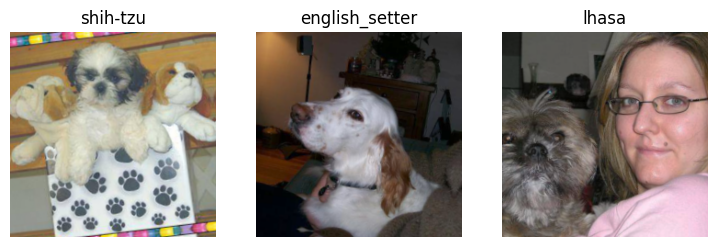

In [14]:
# Show some random training images and their corresonding labels
dls.show_batch(max_n=3)

### Learner

In [15]:
# We use transfer learning to build upon a pre-trained model.
learner = cnn_learner(
    dls,
    arch,
    metrics=[error_rate, accuracy]
)

print(f'Using loss function: {learner.loss_func}')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 56.6MB/s]


Using loss function: FlattenedLoss of CrossEntropyLoss()


### Learning Rate

Suggested learning rate: 0.0012022644514217973, exponential notation: 1.20e-03


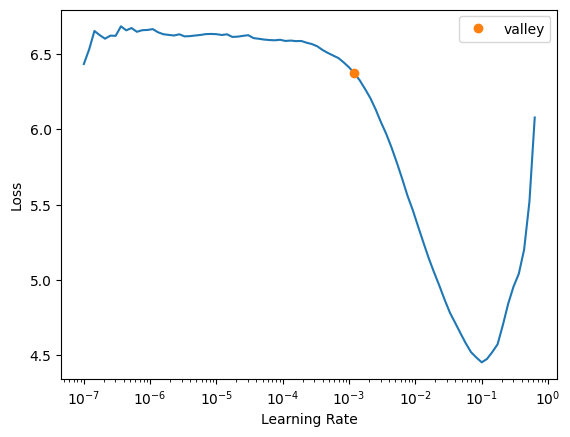

In [16]:
# This helps us find the optimal learning rate and store it and its exponential notation.
lr_sug = learner.lr_find().valley
lr_sug_ex = format(lr_sug, '.2e')

print(f'Suggested learning rate: {lr_sug}, exponential notation: {lr_sug_ex}')

### Fine Tuning (Training)

In [17]:
print(f'Using: {ep} epochs, with a learning rate of: {lr_sug_ex}')

"""
The fine_tune method lets us train/fine-tune our model on a pre-trained model, with new data (dog breeds).
One could use the fit_one_cycle() method but it is more suited towards training a model from scratch
fine_tune does some nice optimization as well.
"""

learner.fine_tune(ep, lr_sug)

print('Fine-tuning (training) complete.')

Using: 10 epochs, with a learning rate of: 1.20e-03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.417822,1.377075,0.371331,0.628669,01:12


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.780931,0.941121,0.252446,0.747554,01:17
1,1.371225,0.721403,0.206947,0.793053,01:15
2,1.068698,0.638210,0.193738,0.806262,01:15
3,0.815113,0.603537,0.180039,0.819961,01:21
4,0.630830,0.582768,0.181996,0.818004,01:18
5,0.490844,0.561703,0.162916,0.837084,01:15
6,0.402425,0.543062,0.171233,0.828767,01:14
7,0.330305,0.541230,0.160470,0.839530,01:14
8,0.285907,0.538763,0.162916,0.837084,01:16
9,0.265653,0.538849,0.162427,0.837573,01:15


Fine-tuning (training) complete.


## Logging

### Training Stats Cleanup

In [ ]:
# Create an array of the validation metrics
val_arr = learner.validate()

In [ ]:
"""
In this step we are combining the training stats from the validation method, and the used hyperparameters.
We do this to get a better understanding of the model, store old training stats, and better know what to tweak.
We are also converting any floating point numbers in the validation array to percentage values.
"""

deci_patt = r'^\d+\.\d{3,}$'

# Loop over the validation array.
for i, x in np.ndenumerate(val_arr):
    # If an array item contains a decimal followd by more than two deciaml points.
    # Turn the values from floating to % values, and only keep two trailning decimal points.
    if re.match(deci_patt, str(x)):
        val_arr[i] = round((x * 100), 2)

# Create a second array to store both the value array and the hyperparameters.
parameters_arr = np.array([ep, bs, lr_sug])

# NEEDED?
# Combine the two arrays into a data frame, and flip the initial col. and rows
df_trained_stats = pd.DataFrame(np.concatenate([val_arr, parameters_arr])).T

# Update the col. labels
df_trained_stats.columns = ['Loss(%)', 'Error(%)', 'Accuracy(%)', 'Epoch', 'Batch Size', 'Learning Rate']

### Training Stats Export

In [ ]:
# In this cell we are creating or updating a JSON file with the df created in the above cell.

# Current time to add to each input
curr_time = datetime.now() 
formatted_time = curr_time.strftime("%d/%m/%y-%H:%M")

# Convert the eariler created df to JSON
trained_stats_json = df_trained_stats.to_json(orient='records')

if not os.path.exists(trained_dir):
    os.mkdir(trained_dir)
    print(f'Created: {trained_dir}')
    
# If the stats file exist, append new data to it, otherwise create the file and add data to it
if os.path.exists(trained_stats): 
    with open(trained_stats, 'r') as f:
        json_obj = json.load(f)
        json_obj[formatted_time] = json.loads(trained_stats_json)
    f.close()
        
    # write the updated JSON data back to the file
    with open(trained_stats, 'w') as f:
        json.dump(json_obj, f, indent=2)
    f.close()
        
    print(f'Added new training stats data to: {trained_stats}')
else:   
    json_obj = {formatted_time: json.loads(trained_stats_json)}
    
    with open(trained_stats, 'w') as f:
        json.dump(json_obj, f, indent=2)
    f.close()
        
    print(f'Created: {trained_stats}')

## Post Training Analysis

In [ ]:
# Lets us look into the different callback functions used during training
learner.show_training_loop()

In [ ]:
# Show a random batch of results from the traning of the model
learner.show_results(max_n=3)

In [ ]:
# Lets us view, interpret and analyze the trained model
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
"""
Plots a heat map matrix that shows us the the distrubution of predicted vs. actual labels
The x-axis show us the predicted labels, and the y-axis show us the actual labels.
The color of each cell in the heat map represents the amount of images that belongs to that class and were classified as another class
"""
interp.plot_confusion_matrix(figsize=(15, 15))

In [ ]:
# The 6 worst predicted images 
interp.plot_top_losses(6, figsize=(15, 10))

In [ ]:
""" 
Lets us view the worst classified classes. 
It gives us the predicted, actual and the number of times the predicition of the class was wrong.
"""
df = pd.DataFrame(data=interp.most_confused(min_val=5))
df.columns = ['Predicted', 'Actual', 'Amount of wrong predictions']
df.head()

## Predictions

In [ ]:
# A function to predict the class and confidence of an image provided by a URL

def predict_img(img):
    print(img)
    pred_class, pred_idx, probs = learner.predict(img)
    conf = probs[pred_idx] * 100
    print(f"Predicted class: {pred_class.capitalize()}, confidence: {conf:.2f}%")

In [ ]:
# Choose an unlabeled, unseen image from the test dataset for prediction

test_img = Path(test_dir).ls()[100]
predict_img(test_img)

In [ ]:
# Here is a function that lets us use BeautifulSoup and the HTTP response library to search and download a random dog image

def rand_dog_image_download():
    url = 'https://www.google.com/search?q=dog&tbm=isch'
    res = requests.get(url)
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(res.content, 'html.parser')
    
    # Fetch all image tags from the page
    img_tags = soup.find_all('img')
    
    # Filter the image tags to only include ones with a src attribute
    img_tags = [img for img in img_tags if 'src' in img.attrs]
    
    # Choose a random image
    random_img_tag = random.choice(img_tags)
    
    # Get the URL of the random image
    img_url = random_img_tag['src']
    
    # Do a HTTP request to get the image content
    img_res = requests.get(img_url)
    
    # Write the random dog image to a file named rand_dog in the working dir.
    with open('rand_dog.jpg', 'wb') as f:
        f.write(img_res.content)
    f.close()
        
    print(f'Downloaded one random dog image from:\n{img_url}')
    
    # Predict the random dog image
    predict_img(os.path.realpath(f.name))

In [ ]:
rand_dog_image_download()

## Export Trained Model

In [ ]:
if export:
    learner.export(trained_model)
    print(f'Created / updated a new trained model file {trained_model}')
else:
    print('Didn\'t export the trained model, change the export variable in the general settings cell.')

## Clean-up

In [ ]:
# TODO